In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import pathlib as plb

In [2]:
WORK_DIR = plb.Path().resolve().parent
DATA_DIR = WORK_DIR / "data"
NOTEBOOKS_DIR = WORK_DIR / "notebooks"
SCRIPTS_DIR = WORK_DIR / "scripts"

HH_DIR = DATA_DIR / "Form 2"

In [3]:
import sys
sys.path.append(str(WORK_DIR))

from scripts import pop_variables as popv

In [4]:
[x for x in HH_DIR.iterdir() if x.is_dir()]

[WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 1 ILOCOS'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 10 NORTHERN MINDANAO'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 11 DAVAO'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 12 SOCCSKSARGEN'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 13 NCR'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 14 CAR'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 15 ARMM'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 16 CARAGA'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 2 CAGAYAN VALLEY'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2/Region 3 CENTRAL LUZON'),
 WindowsPath('D:/WORK/ONLINE COURSES/MINI-PROJECTS/psa_cph/data/Form 2

Population Variables of Interest (Barangay-Level):
- Population (nPOP): `groupby(['REG', 'PRV', 'MUN', 'BGY'])['P2'].count()`
- Sex Ratio (rSX): `P3==1 (male) / P3==2 (female) * 100`
- Working Age Population (nPWA): `sum(P5>=15 AND P<65)`
- Youth Dependency Ratio (rYD): `P5<15 / (P5>=15 AND P<65) * 100`
- Old-Age Dependency Ratio (rOD): `P5>65 / (P5>=15 AND P<65) * 100`
- Total Age Dependency Ratio (rAD): `YDR + ODR`
- School Attendance Rate (rSA): `P10==1 / nPOP` only for ages 5-24<sup>1</sup> <sup>3</sup>
- Literacy Rate (rLT): `P11==1 / nPOP`<sup>1</sup> <sup>3</sup>
- Mean Years of Schooling (mYS): see this [2013 UNESCO document](https://uis.unesco.org/sites/default/files/documents/uis-methodology-for-estimation-of-mean-years-of-schooling-2013-en_0.pdf) for the formula <sup>3</sup>
- Overseas Workers per 1,000 People (ptOFW): `P15==1 / nPOP * 1_000`

Household Variables of Interest (Barangay-Level):
- Number of Households (nHH): `groupby(['REG', 'PRV', 'MUN', 'BGY'])['HSN'].count()`
- Building Type:
    - Percent Single House (pcBT1): `B1==1 / nHH`<sup>1</sup>
    - Percent Duplex (pcBT2): `B1==2 / nHH`<sup>1</sup>
    - Percent Multi-unit Residential (pcBTM): `B1==3 / nHH`<sup>1</sup>
    - Percent Commercial/Industrial/Agricultural (Office, Factory, etc) (pcBTC): `B1==4 / nHH`<sup>1</sup>
    - Percent Institutional Living Quarter (pcILQ): `B1==5 / nHH`<sup>1</sup>
    - Percent Other Housing Units (pcOHU): `B1==6 / nHH`<sup>1</sup>
- Construction Material of Roof:
    - Percent Galvanized Iron/Aluminum (pcRMI): `B2==1 / nHH`<sup>1</sup>
    - Percent Concrete/Clay Tile (pcRMC): `B2==2 / nHH`<sup>1</sup>
    - Percent Half Galvanized Iron and Half Concrete (pcRMH): `B2==3 / nHH`<sup>1</sup>
    - Percent Bamboo/Cogon/Nipa/Anahaw (pcRML): `B2==4 / nHH`<sup>1</sup>
    - Percent Asbestos (pcRMA): `B2==5 / nHH`<sup>1</sup>
    - Percent Makeshift/Salvaged/Improvised Materials (pcRMS): `B2==6 / nHH`<sup>1</sup>
    - Percent Trapal (pcRMT): `B2==7 / nHH`<sup>1</sup>
    - Percent Others (pcRM0): `B2==8 / nHH`<sup>1</sup>
- Construction Material of Outer Walls:
    - Percent Concrete/Brick/Stone (pcOWC): `B3==1 / nHH`<sup>2</sup>
    - Percent Wood (pcOWW): `B3==2 / nHH`<sup>2</sup>
    - Percent Half Concrete/Brick/Stone and Half Wood (pcOWH): `B3==3 / nHH`<sup>2</sup>
    - Percent Galvanized Iron/Aluminum (pcOWI): `B3==4 / nHH`<sup>2</sup>
    - Percent Bamboo/Sawali/Cogon/Nipa (pcOWL): `B3==5 / nHH`<sup>2</sup>
    - Percent Asbestos (pcOWA): `B3==6 / nHH`<sup>2</sup>
    - Percent Glass (pcOWG): `B3==7 / nHH`<sup>2</sup>
    - Percent Makeshift/Salvaged/Improvised Materials (pcOWS): `B3==8 / nHH`<sup>2</sup>
    - Percent Trapal (pcOWT): `B3==9 / nHH`<sup>2</sup>
    - Percent Others (pcOW0): `B2==10 / nHH`<sup>2</sup>
    - Percent No Walls (pcOW_): `B2==11 / nHH`<sup>2</sup>
- Fuel for Lighting:
    - Percent Electricity (pcFLE): `H1==1 / nHH`<sup>1</sup>
    - Percent Kerosene (pcFLK): `H1==2 / nHH`<sup>1</sup>
    - Percent Liquefied Petroleum Gas (pcFLG): `H1==3 / nHH`<sup>1</sup>
    - Percent Oil (Vegetable, Animal, and Others) (pcFLO): `H1==4 / nHH`<sup>1</sup>
    - Percent Solar Panel (pcFLSp): `H1==5 / nHH`<sup>1</sup>
    - Percent Solar Lamp (pcFLSl): `H1==6 / nHH`<sup>1</sup>
    - Percent Others (pcFL0): `H1==7 / nHH`<sup>1</sup>
    - Percent None (pcFL_): `H1==0 / nHH`<sup>1</sup>
- Source of Drinking Water Supply:
    - Percent Own Use Faucet, Community Water System (pcDWFo): `H2==1 / nHH`<sup>2</sup>
    - Percent Shared Faucet, Community Water System (pcDWFs): `H2==2 / nHH`<sup>2</sup>
    - Percent Own Use, Tubed/Piped Deep Well (pcDWDo): `H2==3 / nHH`<sup>2</sup>
    - Percent Shared, Tubed/Piped Deep Well (pcDWDs): `H2==4 / nHH`<sup>2</sup>
    - Percent Tubed/Piped Shallow Well (pcDWS): `H2==5 / nHH`<sup>2</sup>
    - Percent Dug Well (pcDWG): `H2==6 / nHH`<sup>2</sup>
    - Percent Protected Spring (pcDWSp): `H2==7 / nHH`<sup>2</sup>
    - Percent Unprotected Spring (pcDWSu): `H2==8 / nHH`<sup>2</sup>
    - Percent Lake/River/Rain (pcDWL): `H2==9 / nHH`<sup>2</sup>
    - Percent Peddler (pcDWP): `H2==10 / nHH`<sup>2</sup>
    - Percent Bottled Water (pcDWB): `H2==11 / nHH`<sup>2</sup>
    - Percent Others (pcDW0): `H2==12 / nHH`<sup>2</sup>
- Source of Cooking Water Supply:
    - Percent Own Use Faucet, Community Water System (pcKWFo): `H3==1 / nHH`<sup>2</sup>
    - Percent Shared Faucet, Community Water System (pcKWFs): `H3==2 / nHH`<sup>2</sup>
    - Percent Own Use, Tubed/Piped Deep Well (pcKWDo): `H3==3 / nHH`<sup>2</sup>
    - Percent Shared, Tubed/Piped Deep Well (pcKWDs): `H3==4 / nHH`<sup>2</sup>
    - Percent Tubed/Piped Shallow Well (pcKWS): `H3==5 / nHH`<sup>2</sup>
    - Percent Dug Well (pcKWG): `H3==6 / nHH`<sup>2</sup>
    - Percent Protected Spring (pcKWSp): `H3==7 / nHH`<sup>2</sup>
    - Percent Unprotected Spring (pcKWSu): `H3==8 / nHH`<sup>2</sup>
    - Percent Lake/River/Rain (pcKWL): `H3==9 / nHH`<sup>2</sup>
    - Percent Peddler (pcKWP): `H3==10 / nHH`<sup>2</sup>
    - Percent Bottled Water (pcKWB): `H3==11 / nHH`<sup>2</sup>
    - Percent Others (pcKW0): `H3==12 / nHH`<sup>2</sup>
- Tenure Status of Housing Unit/Lot:
    - Percent Own or Owner-Like Possession of House and Lot (pcHLo): `H4==1 / nHH`<sup>1</sup>
    - Percent Rent House/Room, including Lot (pcHLr): `H4==1 / nHH`<sup>1</sup>
    - Percent Own House, Rent Lot (pcHLh): `H4==2 / nHH`<sup>1</sup>
    - Percent Own House, Rent-Free Lot with Consent of Owner (pcHLvc): `H4==3 / nHH`<sup>1</sup>
    - Percent Own House, Rent-Free Lot without Consent of Owner (pcHLvw): `H4==4 / nHH`<sup>1</sup>
    - Percent Rent-free House and Lot with Consent of Owner (pcHLfc): `H4==5 / nHH`<sup>1</sup>
    - Percent Rent-free House and Lot without Consent of Owner (pcHLfw): `H4==6 / nHH`<sup>1</sup>
    - Percent Not Applicable (pcHLn): `H4==1 / nHH`<sup>1</sup>
    

###### <sup>1</sup> do not include `X==9 (not reported)`
###### <sup>2</sup> do not include `X==99 (not reported)`
###### <sup>3</sup> disaggregate by sex `P3==1 vs P3==2`

In [5]:
TEST_DIR = HH_DIR / "Region 1 ILOCOS" / "Ilocos Norte"

name_geolocation = TEST_DIR.name

fp_test_pop = TEST_DIR / f"POPCEN PUF 2015 {name_geolocation} Population.csv"

assert fp_test_pop.exists()

In [6]:
df_test_pop = pd.read_csv(fp_test_pop, na_values=[" " * i for i in range(1, 4)])
df_test_pop.head()

,REG,PRV,PRV_HUC,MUN,BGY,URB,HUSN,HSN,LNO,P2,...,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
0,1,28,2800,1,1,0,1,1,1,1,...,1,2,43,NaN,1.0,130.0,2.0,NaN,2.0,61.0
1,1,28,2800,1,1,0,1,1,2,2,...,1,2,43,NaN,1.0,170.0,2.0,NaN,2.0,9.0
2,1,28,2800,1,1,0,1,1,3,3,...,1,1,38,2.0,1.0,250.0,2.0,NaN,2.0,93.0
3,1,28,2800,1,1,0,1,1,4,4,...,1,1,38,1.0,1.0,170.0,NaN,NaN,NaN,NaN
4,1,28,2800,1,1,0,1,1,5,4,...,1,1,38,1.0,1.0,120.0,NaN,NaN,NaN,NaN


In [7]:
df_test_pop["BGY_PSGC"] = popv.brgy_psgc(df_test_pop)

In [8]:
dict_pop_variables = {
    "nPOP": popv.population(df_test_pop),
    "rSX": popv.sex_ratio(df_test_pop),
    "nPWA": popv.working_age_population(df_test_pop),
    "rYD": popv.youth_dependency_ratio(df_test_pop),
    "rOD": popv.old_age_dependency_ratio(df_test_pop),
    "rSA": popv.school_attendance_rate(df_test_pop),
    "rLT": popv.literacy_rate(df_test_pop),
    "mYS": popv.mean_years_schooling(df_test_pop),
    "ptOFW": popv.ofw_per_1k_people(df_test_pop)
}

df_popv_brgy = pd.DataFrame(dict_pop_variables).reset_index()
df_popv_brgy

,BGY_PSGC,nPOP,rSX,nPWA,rYD,rOD,rSA,rLT,mYS,ptOFW
0,PH012801001,1792,117.212,1147,47.515,8.718,67.013,91.963,8.045,32.366
1,PH012802001,853,101.655,563,41.741,9.769,72.614,98.658,10.252,37.515
2,PH012802002,1596,100.755,1021,47.992,8.325,71.564,98.821,10.164,36.967
3,PH012802003,1413,105.378,936,41.453,9.509,65.549,98.684,9.823,46.709
4,PH012802004,733,103.611,507,30.769,13.807,65.984,97.829,10.387,45.020
...,...,...,...,...,...,...,...,...,...,...
552,PH012823052,1221,102.824,812,36.946,13.424,69.231,99.367,10.824,27.846
553,PH012823053,1064,92.754,701,37.233,14.551,75.989,98.592,11.382,39.474
554,PH012823054,1033,92.007,693,35.498,13.564,70.255,98.340,11.412,52.275
555,PH012823056,1346,105.496,860,40.349,16.163,64.286,95.710,9.225,100.297


<Axes: ylabel='Frequency'>

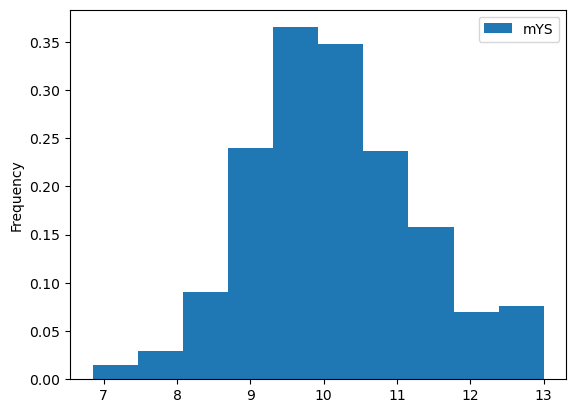

In [9]:
df_popv_brgy.plot(
    kind="hist",
    x="BGY_PSGC",
    y="mYS",
    density=True
)

<Axes: ylabel='Density'>

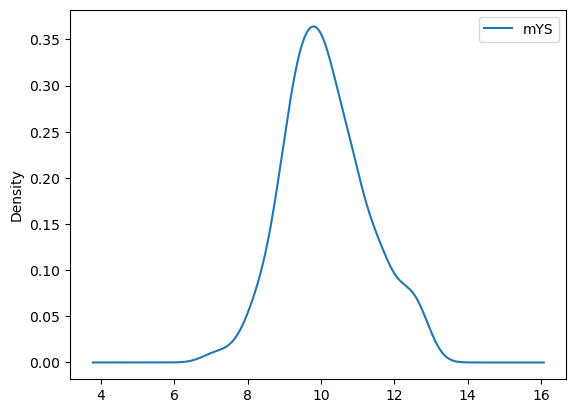

In [10]:
df_popv_brgy.plot(
    kind="density",
    x="BGY_PSGC",
    y="mYS",
)

In [18]:
fp_test_hh = TEST_DIR / "POPCEN PUF 2015 Ilocos Norte Housing.csv"

assert fp_test_hh.exists()

In [20]:
df_test_hh = pd.read_csv(fp_test_hh, na_values=[" " * i for i in range(1, 3)])
df_test_hh.head()

,REG,PRV,PRV_HUC,MUN,BGY,URB,HUSN,HSN,B1,B2,B3,H1,H2,H3,H4,FIRSTHH
0,1,28,2800,1,1,0,1,1,1,1,3,1.0,1.0,1.0,1.0,1.0
1,1,28,2800,1,1,0,2,2,1,1,3,1.0,1.0,1.0,1.0,1.0
2,1,28,2800,1,1,0,3,3,1,1,3,1.0,1.0,1.0,1.0,1.0
3,1,28,2800,1,1,0,4,4,1,1,2,1.0,1.0,1.0,1.0,1.0
4,1,28,2800,1,1,0,5,5,1,1,3,1.0,1.0,1.0,1.0,1.0


In [24]:
pd.crosstab(
    index=[df_test_hh[col] for col in ["B" + str(i) for i in range(1, 4)]],
    columns=[df_test_hh[col] for col in ["H" + str(j) for j in range(1, 5)]],
    margins=True
)

H1        0.0                                      ...  7.0                  \
H2        1.0     2.0     3.0             4.0      ... 11.0                   
H3        1.0     2.0     3.0         6.0 4.0      ...  4.0         5.0       
H4        1.0 4.0 1.0 6.0 1.0 4.0 6.0 1.0 1.0 4.0  ...  4.0 5.0 6.0 3.0 4.0   
B1  B2 B3                                          ...                        
1   1  1    3   1   2   0   4   1   0   0   1   1  ...    1   1   4   0   0   
       2    0   1   0   0   0   0   0   0   1   0  ...    0   0   0   0   1   
       3    0   0   0   0   0   0   0   1   2   0  ...    1   0   0   0   0   
       4    0   0   0   0   0   0   0   0   0   0  ...    0   0   1   0   0   
       5    0   0   0   0   0   0   0   0   0   2  ...    2   0   0   0   0   
...        ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..   
5   4  3    0   0   0   0   0   0   0   0   0   0  ...    0   0   0   0   0   
9   4  5    0   0   0   0   0   0   0   0   0   0  ...    0   0   0   0   0   
    6  8    0   0   0   0   0   0   0   0   0   0  ...    0   0   0   0   0   
    7  9    0   0   0   0   0   0   0   0   0   0  ...    0   0   0   0   0   
All         4   2   2   1   6   1   1   1   5   7  ...    5   1   7   1   1   

H1                             All  
H2                                  
H3        6.0     7.0 11.0          
H4        1.0 4.0 1.0  1.0          
B1  B2 B3                           
1   1  1    1   1   0    1   95462  
       2    0   1   0    0    5268  
       3    0   0   1    0   11847  
       4    0   0   0    0     506  
       5    0   0   0    0    4992  
...        ..  ..  ..  ...     ...  
5   4  3    0   0   0    0       1  
9   4  5    0   0   0    0      74  
    6  8    0   0   0    0       3  
    7  9    0   0   0    0       3  
All         2   5   1    1  139336  

[109 rows x 653 columns]

In [21]:
pd.crosstab?

Signature:
pd.crosstab(
    index,
    columns,
    values=None,
    rownames=None,
    colnames=None,
    aggfunc=None,
    margins: 'bool' = False,
    margins_name: 'Hashable' = 'All',
    dropna: 'bool' = True,
    normalize: 'bool' = False,
) -> 'DataFrame'
Docstring:
Compute a simple cross tabulation of two (or more) factors.

By default, computes a frequency table of the factors unless an
array of values and an aggregation function are passed.

Parameters
----------
index : array-like, Series, or list of arrays/Series
    Values to group by in the rows.
columns : array-like, Series, or list of arrays/Series
    Values to group by in the columns.
values : array-like, optional
    Array of values to aggregate according to the factors.
    Requires `aggfunc` be specified.
rownames : sequence, default None
    If passed, must match number of row arrays passed.
colnames : sequence, default None
    If passed, must match number of column arrays passed.
aggfunc : function, optional
   